<a href="https://colab.research.google.com/github/snghynn/summ/blob/main/dacon_facebook_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Facebook의 fasttext를 이용한 text classification

In [3]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=26de40b136df17ccdcf23f290c0336ecc673acc4213c0de73000cd4252e1f2d8
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [4]:
# library import
import pandas as pd
import numpy as np
import fasttext

In [7]:
# data import
train = pd.read_csv('train.csv')
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [8]:
file = open('fasttexttrain.txt','w+')
for i in train.index:
  line = '__label__' + str(train['author'][i])+' '+train['text'][i]
  file.write(line+"\n")

## Fast text model 학습

In [9]:
text_clf_model = fasttext.train_supervised('fasttexttrain.txt',
                                           epoch = 30, minCount = 2, maxn = 10, verbose = 0)

print(text_clf_model.words)
print(text_clf_model.labels)

['the', 'and', 'to', 'of', '</s>', 'a', 'I', 'in', 'was', 'that', 'he', 'his', 'you', 'with', 'had', 'it', 'odin', 'for', 'as', 'at', 'not', 'my', 'have', 'is', 'be', 'her', 'said', 'on', 'she', 'but', 'odin,', 'all', 'from', 'me', 'by', 'him', 'were', 'which', 'so', 'this', 'been', 'would', 'The', 'an', 'your', 'are', 'very', 'no', 'He', 'one', 'Mr.', 'could', 'what', 'we', 'they', 'will', 'if', 'or', 'upon', 'there', 'when', 'out', 'do', 'who', 'up', '“I', 'some', 'am', 'odin.', 'more', 'into', 'It', 'their', 'about', 'But', 'only', 'should', 'little', 'must', 'than', 'like', 'any', 'know', 'such', 'did', 'man', 'has', 'see', 'And', 'them', 'can', 'our', 'never', 'much', 'come', 'before', 'She', 'down', 'may', 'think', 'how', 'made', 'it,', 'time', 'me,', 'came', 'now', 'great', 'two', 'good', 'might', 'old', 'You', 'over', 'shall', 'after', 'own', 'cried', 'though', 'him,', 'go', 'it.', 'say', 'without', 'even', 'other', 'you,', 'looked', 'Mrs.', 'then', 'Miss', 'thought', 'every', 

In [10]:
reuslt = text_clf_model.predict("He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.", k=5)
print(reuslt)

(('__label__3', '__label__0', '__label__2', '__label__1', '__label__4'), array([9.97099817e-01, 1.53040036e-03, 8.87542381e-04, 3.16065009e-04,
       2.16221946e-04]))


In [14]:
test = pd.read_csv('test_x.csv')
submission = pd.read_csv('sample_submission.csv', index_col=False)

In [15]:
for i in test.index:
    lable, proba = text_clf_model.predict(test['text'][i], k=5)
    for la, pr in zip(lable, proba):
        if '__label__0' == la:
            submission.loc[i, '0'] = pr
        elif '__label__1' == la:
            submission.loc[i, '1'] = pr
        elif '__label__2' == la:
            submission.loc[i, '2'] = pr
        elif '__label__3' == la:
            submission.loc[i, '3'] = pr
        elif '__label__4' == la:
            submission.loc[i, '4'] = pr

# 2. NLP

## 2.0 NLP Preprocessing?
- NLP 전처리는 정해진 정답이 없으며 데이터와 목적에 따라 달라짐
- 모델의 입력인 단어, 문장, 문서의 vector를 만들기 전에 진행이 됨

### [NLP 전처리 과정]

1. 데이터를 불러온 후 각 신문기사들을 눈으로 확인하며 특수문자, 불용어, 문장 구조에 대한 감을 잡음

2. 문제의 목적과 분석자의 재량에 따라 불용어를 설정하고 리스트에 저장. (특수문자, 조사)

3. 불용어 이외의 특수 문자 제거(정규표현식 패키지:re를 사용해 한글과 영어 소문자를 제외한 모든 글자 제거)

4. 형태소 분석을 통해 문장을 형태서 단위의 토큰으로 분리. 설정한 불용어들을 결과로 반환해주는 형태소 분석기를 사용해야 함. (ex. 조사를 불용어로 설정했는데 조사를 분리하지 못하는 형태소 분석기는 후보에서 제거)

5. 형태소 단위의 토큰들을 기반으로 리스트에 저장된 불용어 제거


## 2.1 형태소 분석(Stemming)
- 형태소 분석: 단어나 문장의 언어적 속성을 파악하는 것
- 품사의 태깅(PoS) 통해 이루어짐
- 한국어 형태소 분석을 위해 Konlpy 패키지에 있는 함수 이용하여 진행
- 형태소 단위로 의미있는 단어 추출, 품사 태깅을 통해 형용사나 명사를 추출하고 싶을 때 많이 사용

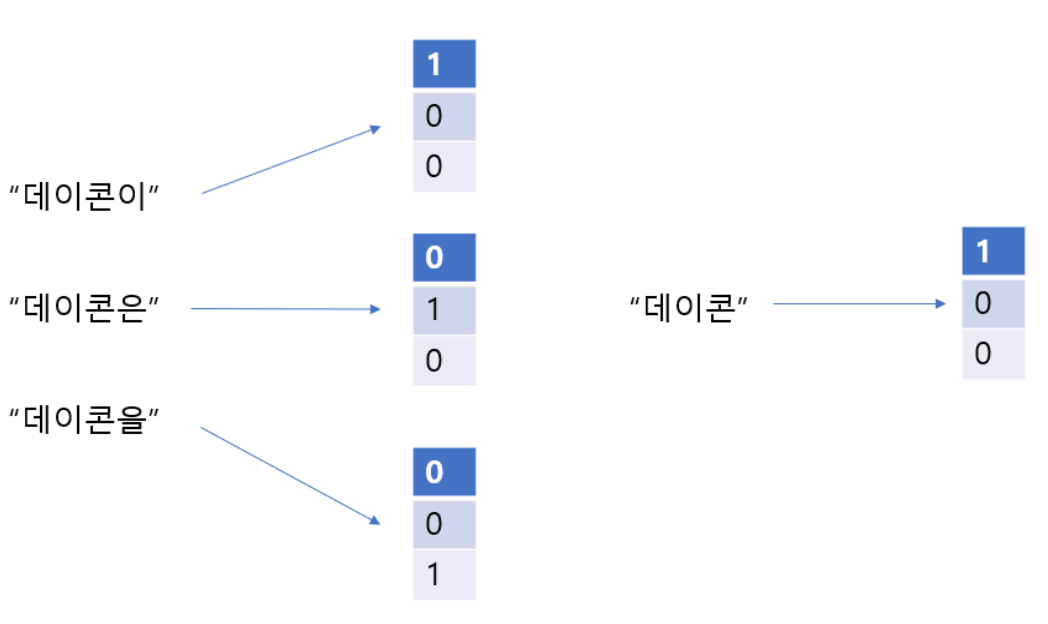

- 문장을 띄어쓰기 단위로 분류하여 vectorization 하게 되면 '데이콘'이라는 같은 의미의 토큰 세개가 서로 다른 vector를 갖게 됨
- 이렇게 되면 모델이 세 단어를 각각 다른 단어로 이해
- 형태소 분석을 통해 '데이콘'이라는 토큰을 추출한다면 앞의 세 단어는 동일한 vector를 갖게됨
- 모델이 해당 토큰을 더 잘 학습하는 데 도움이 됨
- 형태소 분석은 모델링보다 성능에 더 중요한 영향을 미치는 중요한 과정

### 2.1.1 Kkma()

In [16]:
!pip install konlpy
from konlpy.tag import Kkma
kkma = Kkma()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 37.2 MB/s eta 0:00:00


In [17]:
sentence = '데이콘에서 다양한 컴피티션을 즐기면서 실력있는 데이터 분석가로 성장하세요!!.'

print("형태소 단위로 문장 분리")
print("----------------------")
print(kkma.morphs(sentence))
print(" ")
print("문장에서 명사 추출")
print("----------------------")
print(kkma.nouns(sentence))
print(" ")
print("품사 태킹(PoS)")
print("----------------------")
print(kkma.pos(sentence))

형태소 단위로 문장 분리
----------------------
['데이', '콘', '에서', '다양', '하', 'ㄴ', '컴피티션', '을', '즐기', '면서', '실력', '있', '는', '데이터', '분석가', '로', '성장', '하', '세요', '!!', '.']
 
문장에서 명사 추출
----------------------
['데이', '데이콘', '콘', '다양', '컴피티션', '실력', '데이터', '분석가', '성장']
 
품사 태킹(PoS)
----------------------
[('데이', 'NNG'), ('콘', 'NNG'), ('에서', 'JKM'), ('다양', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('컴피티션', 'UN'), ('을', 'JKO'), ('즐기', 'VV'), ('면서', 'ECE'), ('실력', 'NNG'), ('있', 'VV'), ('는', 'ETD'), ('데이터', 'NNG'), ('분석가', 'NNG'), ('로', 'JKM'), ('성장', 'NNG'), ('하', 'XSV'), ('세요', 'EFN'), ('!!', 'SW'), ('.', 'SF')]


### 2.1.2 Okt()

In [18]:
from konlpy.tag import Okt
Okt = Okt()

sentence = '데이콘에서 다양한 컴피티션을 즐기면서 실력있는 데이터 분석가로 성장하세요!!.'

print("형태소 단위로 문장 분리")
print("----------------------")
print(Okt.morphs(sentence))
print(" ")
print("문장에서 명사 추출")
print("----------------------")
print(Okt.nouns(sentence))
print(" ")
print("품사 태킹(PoS)")
print("----------------------")
print(Okt.pos(sentence))

형태소 단위로 문장 분리
----------------------
['데', '이콘', '에서', '다양한', '컴피티션', '을', '즐기면서', '실력', '있는', '데이터', '분석', '가로', '성장하세요', '!!.']
 
문장에서 명사 추출
----------------------
['데', '이콘', '컴피티션', '실력', '데이터', '분석', '가로']
 
품사 태킹(PoS)
----------------------
[('데', 'Noun'), ('이콘', 'Noun'), ('에서', 'Josa'), ('다양한', 'Adjective'), ('컴피티션', 'Noun'), ('을', 'Josa'), ('즐기면서', 'Verb'), ('실력', 'Noun'), ('있는', 'Adjective'), ('데이터', 'Noun'), ('분석', 'Noun'), ('가로', 'Noun'), ('성장하세요', 'Adjective'), ('!!.', 'Punctuation')]


## 2.2 표제어 추출(Lemmatization)
- Lemmatization과 stemming 모두 단어의 본 모습을 찾아주는 과정
- Konpy에서 공개한 형태소 분석기들을 이용하면 어느정도 어간 추출 가능

In [ ]:
from konlpy.tag import Kkma
kkma = Kkma()

sentence = '성장했었다.'

print("품사 태킹(PoS)")
print("----------------------")
print(kkma.pos(sentence))

In [20]:
from konlpy.tag import Kkma
kkma = Kkma()

sentence = '성장했었다.'

print("품사 태킹(PoS)")
print("----------------------")
print(kkma.pos(sentence))

품사 태킹(PoS)
----------------------
[('성장', 'NNG'), ('하', 'XSV'), ('었', 'EPT'), ('었', 'EPT'), ('다', 'EFN'), ('.', 'SF')]


In [21]:
sentence = '성장하였었다.'

print("품사 태킹(PoS)")
print("----------------------")
print(kkma.pos(sentence))

품사 태킹(PoS)
----------------------
[('성장', 'NNG'), ('하', 'XSV'), ('였', 'EPT'), ('었', 'EPT'), ('다', 'EFN'), ('.', 'SF')]


## 2.3 불용어 제거(Stopwords removing)
- 불용어: 문장에서 큰 의미가 없다고 생각되는 단어, 글자들
- 데이터와 문제에 따라 유동적임


In [23]:
from konlpy.tag import Okt
import re
tokenizer = Okt()
def text_preprocessing(text,tokenizer):

    stopwords = ['을', '를', '이', '가', '은', '는']

    txt = re.sub('[^가-힣a-z]', ' ', text)    # 영어 소문자, 한글 제외한 모든 문자 제거
    token = tokenizer.morphs(txt)   # Okt를 이용해 형태소 분석
    token = [t for t in token if t not in stopwords]   # 형태소 분석기를 거쳐 나온 결과들 중 stopwords 리스트에 포함되지 않는 토큰만 token 리스트에 반환

    return token

ex_text = "이번에 새롭게 개봉한 영화의 배우들은 모두 훌륭한 연기력과 아름다운 목소리를 갖고 있어!!"
example_pre = text_preprocessing(ex_text,tokenizer)

In [24]:
# 위의 결과
print(example_pre)

['이번', '에', '새롭게', '개봉', '한', '영화', '의', '배우', '들', '모두', '훌륭한', '연기력', '과', '아름다운', '목소리', '갖고', '있어']


## 2.4 대회 적용

In [26]:
def text_preprocessing(text,tokenizer):
  stopwords = ['을', '를', '이', '가', '은', '는'] # 불용어 정의

  txt = re.sub('[^가-힣a-z]', ' ', text) # 영어 소문자와 한글을 제외한 모든 문자를 제거
  token = tokenizer.morphs(txt) # 형태소 분석
  token = [t for t in token if t not in stopwords] # 형태소 분석기를 거쳐 나온 결과들 중
                                                   # stopwords 리스트에 포함되지 않는 토큰만 저장

  return token

ex_text = "이번에 새롭게 개봉한 영화의 배우들은 모두 훌륭한 연기력과 아름다운 목소리를 갖고 있어!!"
example_pre= text_preprocessing(ex_text,tokenizer)

In [27]:
print(example_pre)

['이번', '에', '새롭게', '개봉', '한', '영화', '의', '배우', '들', '모두', '훌륭한', '연기력', '과', '아름다운', '목소리', '갖고', '있어']


In [28]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


# 3. Vectorization

## 3.0 Vectorization
- NLP를 컴퓨터가 이해할 수 있게 수치로 바꾸는 것
- vocabulary: 벡터로 변환된 고유의 토큰들이 모힌 집합
- vocabulary가 클수록 학습이 오래 걸림
- 토큰들을 벡터화하기 이전에 형태소 분석기를 사용해 문장을 원하는 토큰으로 분리

### [전처리와 okt 활용해 토큰으로 나누기]
다음의 문장을 전처리 및 okt


Ex) 자연어 처리는 정말 즐거워. 즐거운 자연어 처리 다같이 해보자

In [30]:
from konlpy.tag import Okt
import re

Okt = Okt()

sentences = ['자연어 처리는 정말 정말 즐거워.', '즐거운 자연어 처리 다같이 해보자.']
tokens = []

for sentence in sentences:
  sentence = re.sub('[^가-힣a-z]', ' ', sentence) # 간단한 전처리
  token = (Okt.morphs(sentence)) # 형태소 분석기를 이용햔 토큰 나누기
  tokens.append(' '.join(token))

print("형태소 단위로 문장 분리")
print("----------------------")
print(tokens)

형태소 단위로 문장 분리
----------------------
['자연어 처리 는 정말 정말 즐거워', '즐거운 자연어 처리 다 같이 해보자']


## 3.1 One Hot Encoding
- 1: 해당 단어가 존재
- 0: 해당 단어가 존재 X
- keras 이용해 구현 가능
- texts_to_sequences 활용해 각 토큰에 고유한 정수 부여 후 to_categorical 활용

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# 토큰화
t = Tokenizer()
t.fit_on_texts(tokens)
print("각 토큰에게 고유의 정수 부여")
print("----------------------")
print(t.word_index)
print(" ")

s1 = t.texts_to_sequences(tokens)[0]
print("부여된 정수로 표시된 문장1")
print("----------------------")
print(s1)
print(" ")
s2 = t.texts_to_sequences(tokens)[1]
print("부여된 정수로 표시된 문장2")
print("----------------------")
print(s2)
print(" ")

# One-hot Encoding
s1_one_hot = to_categorical(s1)
print("문장1의 one-hot-encoding")
print("----------------------")
print(s1_one_hot)
print(" ")
s2_one_hot = to_categorical(s2)
print("문장2의 one-hot-encoding")
print("----------------------")
print(s2_one_hot)

각 토큰에게 고유의 정수 부여
----------------------
{'자연어': 1, '처리': 2, '정말': 3, '는': 4, '즐거워': 5, '즐거운': 6, '다': 7, '같이': 8, '해보자': 9}
 
부여된 정수로 표시된 문장1
----------------------
[1, 2, 4, 3, 3, 5]
 
부여된 정수로 표시된 문장2
----------------------
[6, 1, 2, 7, 8, 9]
 
문장1의 one-hot-encoding
----------------------
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
 
문장2의 one-hot-encoding
----------------------
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


>- 이 방식은 vocabulary 크기가 커짐에 따라 많은 공간을 차지
- 벡터가 굉장히 sparse(부족)해지기 때문에 모델에게 좋은 특성을 알려주지 못하는 경우가 대부분

## 3.2 Count vectorization
- vocabulary를 활용해 각 문장이 갖고 있는 토큰의 count 기반으로 문장을 vectorization해줌


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(tokens) # 여러 개의 문장을 넣어줘야 작동합니다!!

print(vectorizer.get_feature_names_out())
print(vectors.toarray())

['같이' '자연어' '정말' '즐거운' '즐거워' '처리' '해보자']
[[0 1 2 0 1 1 0]
 [1 1 0 1 0 1 1]]


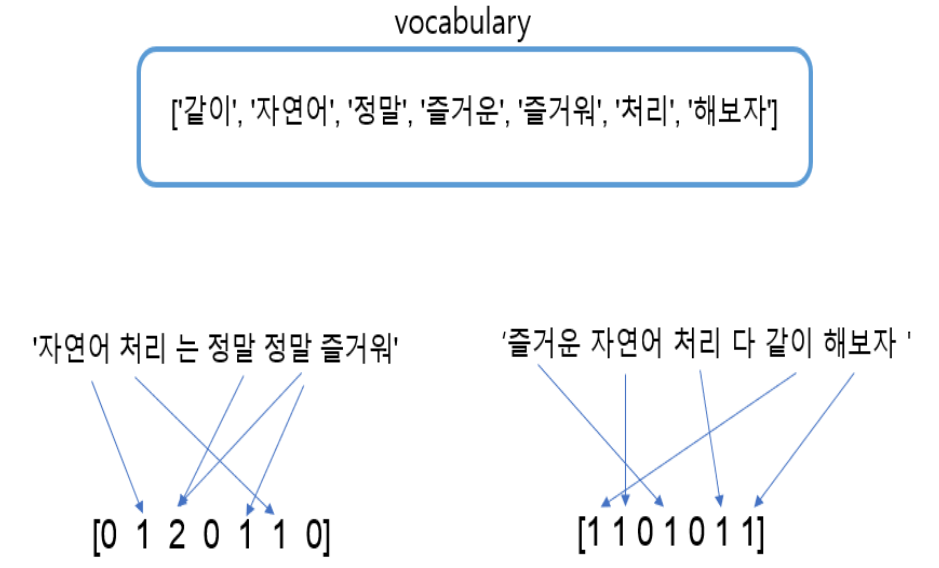

>- 벡터화 결과 각 문장은 vocabulary의 인덱스를 기준으로 카운트가 정수로 표시됨
- 단점) sklearn의 CountVectorizer는 한 글자는 자동으로 제거
- 즐거운과 즐거워는 같은 의미를 가진 토큰이지만 okt는 이를 다른 토큰으로 분리

## 3.3 Tfldf
- Tfldf의 핵심
1. 단어가 몇 번 등장했는지에 대한 정보

2. 어떤 단어가 언급된 문서의 수가 적다면 그 단어는 문서를 분류하는 데에 중요한 단어

- 등장횟수도 많고 문서 분별력이 있는 단어들을 점수화하여 벡터화를 한 것

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 0)
tfidf_vectorizer = tfidf.fit_transform(tokens)

# tf-idf dictionary
tfidf_dict = tfidf.get_feature_names_out()
print(tfidf_dict)
print(tfidf_vectorizer.toarray())

['같이' '자연어' '정말' '즐거운' '즐거워' '처리' '해보자']
[[0.         0.29017021 0.81564821 0.         0.4078241  0.29017021
  0.        ]
 [0.49922133 0.35520009 0.         0.49922133 0.         0.35520009
  0.49922133]]


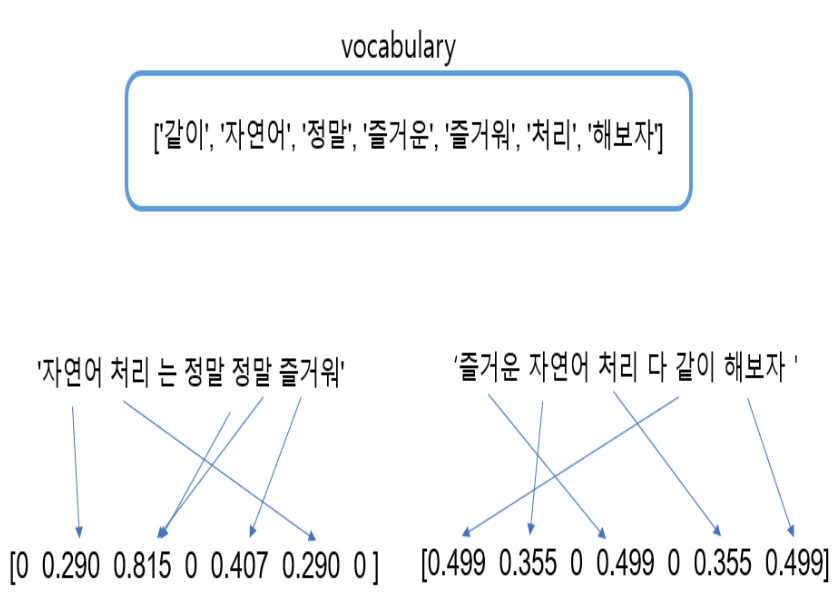

## 3.4 Padding
- row(문장)별 column(토큰의 개수)이 같지 않아도 되는 것인가?
- Padding: 문장의 길이를 맞추기 위해 부족한 길이만큼 0을 채워넣는 것

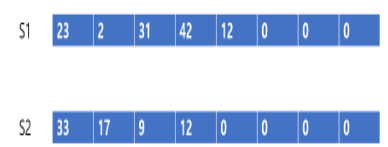

- 문장 S1의 길이와 S2의 길이가 서로 다를 때 뒤쪽에 0을 padding해 같은 길이로 맞춤
- keras 통해 padding 구현 가능

## 3.5 대회 적용

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # 정수화

def text2sequence(train_text, max_len=100):
  tokenizer = Tokenizer() # keras의 vectorizing 함수 호출
  tokenizer.fit_on_texts(train_text) # train 문장에 fit
  train_X_seq = tokenizer.texts_to_sequences(train_text) # 각 토큰들에 정수 부여(자연어 -> 정수)
  vocab_size = len(tokenizer.word_index) + 1 # 모델에 알려줄 vocabulary의 크기 계산
  print('vocab_size : ', vocab_size)
  X_train = pad_sequences(train_X_seq, maxlen = max_len) # 설정한 문장의 최대 길이만큼 padding

  return X_train, vocab_size, tokenizer

train_X, vocab_size, vectorizer = text2sequence(train['text'], max_len = 100)

vocab_size :  42331


>- Vectorization의 문제를 해결해주는 것이 Embedding